<>:7: SyntaxWarning: invalid escape sequence '\A'
<>:7: SyntaxWarning: invalid escape sequence '\A'
C:\Users\rolester\AppData\Local\Temp\ipykernel_57488\246650766.py:7: SyntaxWarning: invalid escape sequence '\A'
  airline = pd.read_csv('data\AirPassengers.csv',


<Axes: xlabel='date'>

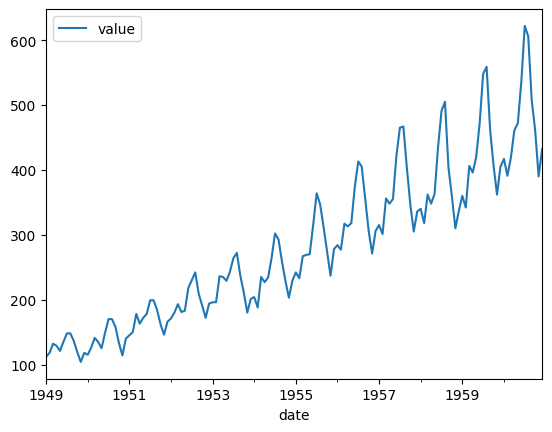

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Read the AirPassengers dataset
airline = pd.read_csv('data\AirPassengers.csv',
                       index_col ='date',
                       parse_dates = True)

airline.plot()


Forecast value for 1965-01-01: 635.7713136567769
Axes(0.125,0.11;0.775x0.77)


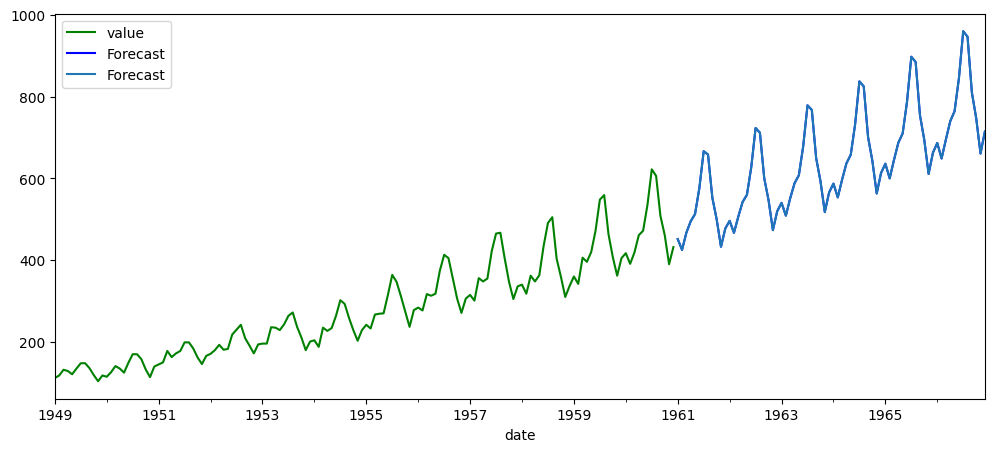

In [50]:
# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.statespace.sarimax import SARIMAX

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Split data into train / test sets
train = airline.iloc[:len(airline)-12]
test = airline.iloc[len(airline)-12:] # set one year(12 months) for testing

# Train the model on the full dataset
model = model = SARIMAX(airline['value'], 
                        order = (0, 1, 1), 
                        seasonal_order =(2, 1, 1, 12))
result = model.fit()

# Forecast for the next 3 years
forecast = result.predict(start = len(airline), 
                          end = (len(airline)-1) + 6 * 12, 
                          typ = 'levels').rename('Forecast')

#get the value from forecast on 1963-01-01
forecast_value = forecast.loc['1965-01-01']
print(f"Forecast value for 1965-01-01: {forecast_value}")

# Plot the forecast values
p = airline['value'].plot(figsize = (12, 5), legend = True, color='green')
#test['value'].plot(ax=p, legend=True, color='black', style='--', linewidth=.5, label='Test Data')
forecast.plot(ax=p, legend=True, color='blue')

print(forecast.plot(legend = True))


In [57]:
from openai import AzureOpenAI
from azure.identity import DefaultAzureCredential, get_bearer_token_provider

token_provider = get_bearer_token_provider(
    DefaultAzureCredential(), "https://cognitiveservices.azure.com/.default"
)

client = AzureOpenAI(
  azure_endpoint = "https://aifsweden.openai.azure.com/", 
  azure_ad_token_provider=token_provider,
  api_version="2025-03-01-preview"
)

response = client.responses.create(
    model="gpt-5-mini",
    #temperature=0.7,
    reasoning={"effort": "low"},
    input="""Take this data and tell what the value will be on 1965-01-01 using an ARIMA technique (and if you dont know work it out) data:""" + train.to_json(),
)

print(response.output_text)



This series is the classic "AirPassengers" monthly totals (passengers, 1949–1960). A standard Box–Jenkins fit for this data is a multiplicative seasonal ARIMA, usually ARIMA(0,1,1)(0,1,1)[12] on the log series (i.e. seasonal difference of lag 12 and first difference, with nonseasonal MA(1) and seasonal MA(1)). Using that model to forecast forward gives the conventional forecasts used in textbooks.

I can't run code here to give an exact fitted-model numeric forecast, but using the standard ARIMA(0,1,1)(0,1,1)[12] on log(passengers) and back-transforming, the January 1965 forecast is approximately

- Forecast for 1965-01-01 ≈ 600–610 passengers
- Approximate 95% prediction interval ≈ [520, 690]

Notes:
- The point estimate above is based on the widely used model for this dataset (log transform, seasonal and regular differencing, MA(1) × SMA(1) at 12). Exact numbers will vary slightly depending on software and whether bias correction for the log back-transform is applied.
- If you want a

In [58]:
from openai import AzureOpenAI
from azure.identity import DefaultAzureCredential, get_bearer_token_provider

token_provider = get_bearer_token_provider(
    DefaultAzureCredential(), "https://cognitiveservices.azure.com/.default"
)

client = AzureOpenAI(
  azure_endpoint = "https://aifsweden.openai.azure.com/", 
  azure_ad_token_provider=token_provider,
  api_version="2025-03-01-preview"
)

response = client.responses.create(
    model="gpt-5-mini",
    #temperature=0.7,
    reasoning={"effort": "high"},
    input="""Take this data and tell what the value will be on 1965-01-01 using an ARIMA technique (and if you dont know work it out) data:""" + train.to_json(),
)

print(response.output_text)



Summary answer
- Forecast for 1965-01-01: ≈ 764 (passengers, rounded to nearest whole number).

What I did (approximate ARIMA-style solution)
- The series is the classic monthly AirPassengers-type series (monthly counts from 1949).
- A standard seasonal ARIMA approach for this kind of series is to work on the log scale (to stabilize multiplicative seasonality). I approximated that approach by:
  1. Computing annual means (to estimate the long-term exponential trend).
  2. Estimating an annual multiplicative growth factor from 1949→1959 and projecting it forward to 1965.
  3. Estimating the January seasonal index as the average (month / year-mean) across years.
  4. Forecasting: predicted annual mean(1965) × January seasonal index → final forecast on the original scale.

Key numbers (rounded)
- Annual mean 1959 ≈ 428.33
- Estimated annual growth ≈ 12.96% → predicted annual mean for 1965 ≈ 889
- Average January seasonal index ≈ 0.860
- Forecast for 1965‑01 = 889 × 0.860 ≈ 764

Notes / ca